# Verify KAW dispersion relation in drifting core + drifting kappa halo plasma

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from util import (
    gen_input_file_text,
    get_wave_number, 
    get_initial_guess, 
    get_setup, 
    get_accuracy, 
    get_species,
    write_input_data,
    read_disp_data,
)

import subprocess

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
mpl.rcParams['legend.fontsize'] = 14
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points
%matplotlib inline

%load_ext autoreload
%autoreload 2
%matplotlib inline

## multiple species (density ratio)

### baseline

In [13]:
input_params = {}
input_params['kstart'] = .2
input_params['kend'] = 2.5 
input_params['nk'] = 60
input_params['nspecies'] = 3
input_params['theta'] = 80
input_params['q_in'] = np.array([1., -1., -1.])
input_params['mu_in'] = np.array([1., 1836., 1836.])
input_params['dens_in'] = np.array([1., .9, .1])
input_params['vdc_va'] = 3.0
input_params['drift_in'] = np.array([
    0., input_params['vdc_va'], 
    -input_params['dens_in'][1]/input_params['dens_in'][2]*input_params['vdc_va']
])
input_params['beta'] = .25
t_in = np.array([1, 2, 12])
beta_0 = .25
input_params['beta_para_in'] = beta_0 * t_in * input_params['dens_in']
input_params['beta_perp_in'] = beta_0 * t_in * input_params['dens_in']
input_params['kappa_in'] = np.array([50, 50, 50])
input_params['delta'] = 1e-4 # v_A/c

input_params['omega_r'] = input_params['kstart'] * np.cos(np.deg2rad(input_params['theta'])) * \
    (1 + input_params['drift_in'][0])
input_params['omega_i'] = -1e-6
input_params['increment_r'] = 0 # (kend - kstart) / nk * np.cos(np.deg2rad(theta))
input_params['increment_i'] = 0

### modify kappas

In [15]:
input_file_text = gen_input_file_text(input_params)
write_input_data(input_file_text)
subprocess.run(["./../dsolve"])
disp = read_disp_data()

In [22]:
test_kappas = [np.array([50, 50, 4]), np.array([50, 50, 8]), np.array([50, 50, 16]), np.array([50, 50, 32])]
test_disps = []
for kappa_in in test_kappas:
    test_input_params = input_params.copy()
    test_input_params['kappa_in'] = kappa_in
    input_file_text = gen_input_file_text(test_input_params)
    write_input_data(input_file_text)
    subprocess.run(["./../dsolve"])
    test_disps.append(read_disp_data())   

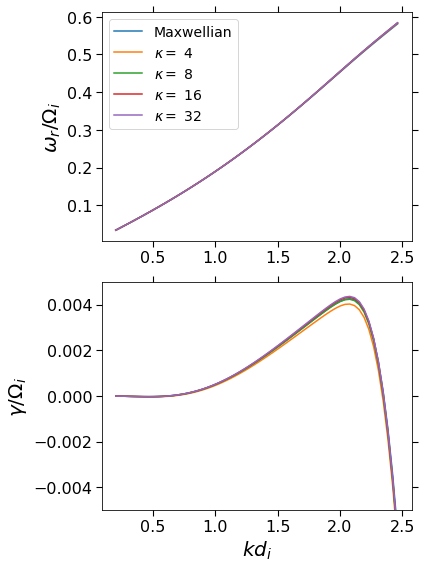

In [23]:
plt.figure(figsize=[6, 8])
plt.subplot(211)
plt.plot(disp.k, disp.wr, label='Maxwellian')
for i, test_disp in enumerate(test_disps):
    plt.plot(test_disp.k, test_disp.wr, label=r'$\kappa=$ {0}'.format(test_kappas[i][2]))
plt.ylabel(r'$\omega_r/\Omega_i$')
plt.legend()
plt.subplot(212)
plt.plot(disp.k, disp.wi, label='Maxwellian')
for i, test_disp in enumerate(test_disps):
    plt.plot(test_disp.k, test_disp.wi, label=r'$\kappa=$ {0}'.format(test_kappas[i][2]))
plt.ylim([-5e-3, 5e-3])
plt.xlabel(r'$kd_i$')
plt.ylabel(r'$\gamma/\Omega_i$')
plt.tight_layout()
# plt.savefig('figures/kappa_halo_effect.png', dpi=200)
plt.show()

## mass ratio

In [75]:
test_masses = [np.array([1., 400., 400.]), np.array([1., 900., 900.]), np.array([1., 6400., 6400.])]
test_disps = []
for mu_in in test_masses:
    test_input_params = input_params.copy()
    test_input_params['mu_in'] = mu_in
    input_file_text = gen_input_file_text(test_input_params)
    write_input_data(input_file_text)
    subprocess.run(["./dsolve"])
    test_disps.append(read_disp_data())

Text(0,0.5,'$\\gamma/\\Omega_i$')

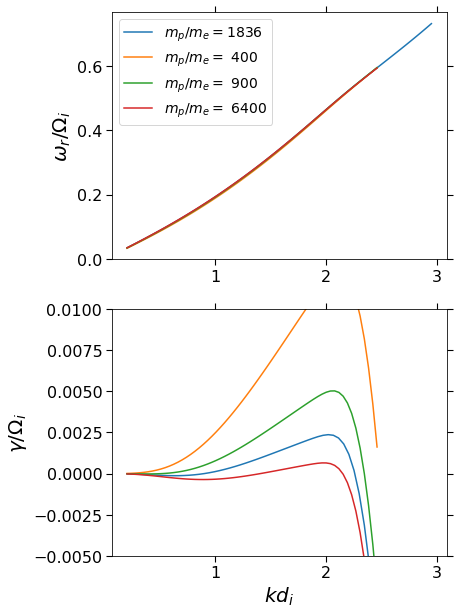

In [83]:
plt.figure(figsize=[6, 10])
plt.subplot(211)
plt.plot(disp.k, disp.wr, label=r'$m_p/m_e=1836$')
for i, test_disp in enumerate(test_disps):
    plt.plot(test_disp.k, test_disp.wr, label=r'$m_p/m_e=$ {0}'.format(int(test_masses[i][2])))
plt.ylabel(r'$\omega_r/\Omega_i$')
plt.legend()
plt.subplot(212)
plt.plot(disp.k, disp.wi, label='Maxwellian')
for i, test_disp in enumerate(test_disps):
    plt.plot(test_disp.k, test_disp.wi, label=r'$m_p/m_e=$ {0}'.format(test_masses[i][2]))
plt.ylim([-5e-3, 1e-2])
plt.xlabel(r'$kd_i$')
plt.ylabel(r'$\gamma/\Omega_i$')